# Geomedian
<img src="https://arcgis01.satapps.org/portal/sharing/rest/content/items/a499849ccd1f4c7fb0403b4c719f9dc1/resources/Geomedian.png" />

[find out more](https://arcgis01.satapps.org/portal/apps/sites/?fromEdit=true#/data/pages/data-cube)
The geomedian is a composite of surface reflectance for each of the spectral bands over a time period, it can be used to obtain a cloud-free image. 



In [1]:
# jupyteronly
%load_ext autoreload
%autoreload 2
%matplotlib inline
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image

In [2]:
# generic python
import xarray as xr 
from shapely import wkt
from datetime import datetime
import numpy as np
import yaml
import rioxarray as rxr
import glob

# Import functions to load and stack data without datacube
from notebook_functions import *

import dask
import dask.array as da
from dask.distributed import Client
client = Client(n_workers=2, threads_per_worker=4, memory_limit='7GB')

client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 8,Total memory: 13.04 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40501,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 13.04 GiB
Comm: tcp://127.0.0.1:38639,Total threads: 4
Dashboard: http://127.0.0.1:34555/status,Memory: 6.52 GiB
Nanny: tcp://127.0.0.1:43233,


## Set Up Parameters

In [3]:
# Running locally on landsat 8 data for now
product = 'landsat_8'

# St Maarten bounding box to subset the data
clip_coords = {'min_lon':-63.461424,
               'min_lat': 17.950000,
               'max_lon': -62.80000,
               'max_lat': 18.334848}

# Set size of dask chunks to use for the scenes
dask_chunks = dict(
    x = 1000,
    y = 1000
)

# Set mosaic type (options: 'median', 'mean', 'max', 'min')
mosaic_type = 'median'


measurements = ["blue", "green", "red", "nir", "swir1", "swir2", "pixel_qa"]


#parameter display_name="Water Mask" description="If you would like the water to be masked out choose YES, if you would like the full image choose NO" datatype="string" options=["YES", "NO"],
mask_water = 'YES'


## Load Data

In [4]:
def prep_dataset(in_dir, measurement, product, clip_coords = None):
    """Prepare either the baseline or analysis dataset."""
    scenes = glob.glob(f'{in_dir}/*/')

    array_list = []

    for scene in scenes:
        yml = f'{scene}/datacube-metadata.yaml'
        with open (yml) as stream: yml_meta = yaml.safe_load(stream)

        # Load the bands provided in 'measurement' from the yaml file.
        o_bands_data = [ rxr.open_rasterio(scene + yml_meta['image']['bands'][b]['path'], chunks=dask_chunks) for b in measurement ] 

        # Clip the data to the bounding box if provided.
        if clip_coords is not None:
            o_bands_data = [ o_bands_data[i].rio.clip_box(minx = clip_coords['min_lon'], miny = clip_coords['min_lat'], 
                                                          maxx = clip_coords['max_lon'], maxy = clip_coords['max_lat']) 
                                                          for i in range(len(o_bands_data)) ]

        # Get the timestamp from the yaml file.
        timestamp = datetime.strptime(yml_meta['extent']['center_dt'], '%Y-%m-%d %H:%M:%S')

        # Stack the bands together into a single xarray dataset.
        band_data = stack_bands(o_bands_data, measurement, timestamp)

        # Append each stacked scene to a list to be combined later.
        array_list.append(band_data)

    # Stack the scenes together into xarray dataset.
    ds = stack_scenes(array_list)

    # Mask out nodata values.
    ds = ds.where(ds != -9999)
    print(f'Final Dataset: {ds}')

    return ds

In [5]:
# Running on data from St Maarten
dir = '/home/spatialdays/Documents/ARD_Data/StMaarten_Landsat/'
ds = prep_dataset(dir, measurements, product, clip_coords)

## Run data for Tile7572 
# dir = '/home/spatialdays/Documents/testing-wofs/test_masking/Tile7572/BaselineData/'
# ds = prep_dataset(dir, allmeasurements, product)

Final Dataset: <xarray.Dataset>
Dimensions:      (time: 7, y: 1429, x: 2455)
Coordinates:
    spatial_ref  int64 0
  * x            (x) float64 -63.46 -63.46 -63.46 -63.46 ... -62.8 -62.8 -62.8
  * y            (y) float64 18.33 18.33 18.33 18.33 ... 17.95 17.95 17.95 17.95
  * time         (time) datetime64[ns] 2018-09-06 2022-11-20 ... 2018-03-14
Data variables:
    blue         (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    green        (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    red          (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    nir          (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    swir1        (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    swir2        (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    pixel_qa     (time, y, x) float64 dask.array<chunksize=(1, 1000, 1000),

## Cloud Masking

In [15]:
# Use the landsat clean mask function to mask out clouds and water.
#clean_mask = ls_clean_mask(ds, keep_water=True)
clean_mask = ls_cloud_mask(ds)

## Create Composites

In [16]:
def create_temporal_composite(dataset, mosaic_type, clean_mask=None):
    if clean_mask is not None:
        dataset = dataset.where(clean_mask == 1, np.nan)
    
    # Select and run the mosaic type
    if mosaic_type in ['mean']:
        composite = dataset.mean(dim=['time'])
    elif mosaic_type in ['max']:
        composite = dataset.max(dim=['time'])
    elif mosaic_type in ['min']:
        composite = dataset.min(dim=['time'])
    elif mosaic_type in ['median']:
        composite = dataset.median(dim=['time'])
    else:
        print('invalid mosaic')
    
    return composite

# Create composites (summarizing through time) of the baseline and analysis datasets
ds_composite = create_temporal_composite(ds, mosaic_type='median', clean_mask = clean_mask)

In [17]:
from odc.algo import xr_geomedian, to_rgba, to_f32
from odc.ui import to_png_data
#import hdstats

# Drop the pixel_qa band from the dataset
ds_analysis = ds.drop(['pixel_qa', 'swir1', 'swir2'])

ds_clean = ds_analysis.where(clean_mask == 1, np.nan)

scale, offset = (1, 0)

ds_clean_32 = to_f32(ds_clean, scale=scale, offset=offset)

yy = xr_geomedian(ds_clean_32, 
                  num_threads=1,  # disable internal threading, dask will run several concurrently
                  #axis='time',
                  eps=0.2*(1/10_000),  # 1/5 pixel value resolution
                  nocheck=True) 

yy

<xarray.Dataset>
Dimensions:  (y: 1429, x: 2455)
Coordinates:
  * y        (y) float64 18.33 18.33 18.33 18.33 ... 17.95 17.95 17.95 17.95
  * x        (x) float64 -63.46 -63.46 -63.46 -63.46 ... -62.8 -62.8 -62.8 -62.8
Data variables:
    blue     (y, x) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    green    (y, x) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    red      (y, x) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    nir      (y, x) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>

In [9]:
# Print data type of ds_clean
yy.compute()


/home/spatialdays/anaconda3/envs/notebooks/lib/python3.11/site-packages/odc/algo/_geomedian.py:99: RuntimeWarning: Mean of empty slice
  lambda x: nangeomedian_pcm(x, **kw),
/home/spatialdays/anaconda3/envs/notebooks/lib/python3.11/site-packages/odc/algo/_geomedian.py:99: RuntimeWarning: Mean of empty slice
  lambda x: nangeomedian_pcm(x, **kw),
/home/spatialdays/anaconda3/envs/notebooks/lib/python3.11/site-packages/odc/algo/_geomedian.py:99: RuntimeWarning: Mean of empty slice
  lambda x: nangeomedian_pcm(x, **kw),
/home/spatialdays/anaconda3/envs/notebooks/lib/python3.11/site-packages/odc/algo/_geomedian.py:99: RuntimeWarning: Mean of empty slice
  lambda x: nangeomedian_pcm(x, **kw),
/home/spatialdays/anaconda3/envs/notebooks/lib/python3.11/site-packages/odc/algo/_geomedian.py:99: RuntimeWarning: Mean of empty slice
  lambda x: nangeomedian_pcm(x, **kw),


<xarray.Dataset>
Dimensions:   (y: 1429, x: 2455)
Coordinates:
  * y         (y) float64 18.33 18.33 18.33 18.33 ... 17.95 17.95 17.95 17.95
  * x         (x) float64 -63.46 -63.46 -63.46 -63.46 ... -62.8 -62.8 -62.8
Data variables:
    blue      (y, x) float32 0.007591 0.006747 0.005756 0.006751 ... 0.0 0.0 0.0
    green     (y, x) float32 0.003185 0.00311 0.002961 0.003682 ... 0.0 0.0 0.0
    red       (y, x) float32 -0.001307 -0.001535 -0.001873 ... 0.0 0.0 0.0
    nir       (y, x) float32 0.002164 0.002396 0.002791 0.003235 ... 0.0 0.0 0.0
    swir1     (y, x) float32 0.01088 0.01206 0.0138 0.01388 ... 0.0 0.0 0.0 0.0
    swir2     (y, x) float32 0.01015 0.01143 0.0132 0.01313 ... 0.0 0.0 0.0 0.0
    pixel_qa  (y, x) float32 2.195e+04 2.195e+04 2.195e+04 ... 0.0 0.0 0.0

In [19]:
yy.head().compute()

/home/spatialdays/anaconda3/envs/notebooks/lib/python3.11/site-packages/odc/algo/_geomedian.py:99: RuntimeWarning: Mean of empty slice
  lambda x: nangeomedian_pcm(x, **kw),


<xarray.Dataset>
Dimensions:  (y: 5, x: 5)
Coordinates:
  * y        (y) float64 18.33 18.33 18.33 18.33 18.33
  * x        (x) float64 -63.46 -63.46 -63.46 -63.46 -63.46
Data variables:
    blue     (y, x) float32 0.006933 0.006204 0.005549 ... 0.003815 0.005677
    green    (y, x) float32 0.003174 0.002698 0.002644 ... 0.002127 0.002935
    red      (y, x) float32 -0.001441 -0.001979 ... -0.002907 -0.001962
    nir      (y, x) float32 0.002097 0.00158 0.00183 ... 0.001949 0.001942

In [25]:
def normalize_0_1(band):
    """Normalize band ranges between 0 and 1 for image display purposes."""
    band_min, band_max = (band.min(), band.max())
    return ((band-band_min)/((band_max - band_min)))

def gammacorr(band):
    """Apply gamma correction to the band (brightens image)."""
    gamma=2
    return np.power(band, 1/gamma)


red_g = gammacorr(yy.red)
green_g = gammacorr(yy.green)
blue_g = gammacorr(yy.blue)


red_n = normalize_0_1(red_g)
green_n = normalize_0_1(green_g)
blue_n = normalize_0_1(blue_g)

rgb_stack = np.dstack((red_n, green_n, blue_n))



/home/spatialdays/anaconda3/envs/notebooks/lib/python3.11/site-packages/odc/algo/_geomedian.py:99: RuntimeWarning: Mean of empty slice
  lambda x: nangeomedian_pcm(x, **kw),
/home/spatialdays/anaconda3/envs/notebooks/lib/python3.11/site-packages/odc/algo/_geomedian.py:99: RuntimeWarning: Mean of empty slice
  lambda x: nangeomedian_pcm(x, **kw),
/home/spatialdays/anaconda3/envs/notebooks/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in power
  return func(*(_execute_task(a, cache) for a in args))
/home/spatialdays/anaconda3/envs/notebooks/lib/python3.11/site-packages/odc/algo/_geomedian.py:99: RuntimeWarning: Mean of empty slice
  lambda x: nangeomedian_pcm(x, **kw),
/home/spatialdays/anaconda3/envs/notebooks/lib/python3.11/site-packages/odc/algo/_geomedian.py:99: RuntimeWarning: Mean of empty slice
  lambda x: nangeomedian_pcm(x, **kw),
/home/spatialdays/anaconda3/envs/notebooks/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: i

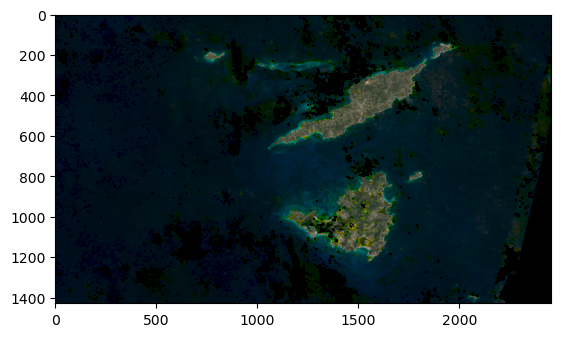

In [26]:
plt.imshow(rgb_stack)

In [19]:
yy.rio.to_raster('geomedian.tif')

/home/spatialdays/anaconda3/envs/notebooks/lib/python3.11/site-packages/odc/algo/_geomedian.py:99: RuntimeWarning: Mean of empty slice
  lambda x: nangeomedian_pcm(x, **kw),
/home/spatialdays/anaconda3/envs/notebooks/lib/python3.11/site-packages/odc/algo/_geomedian.py:99: RuntimeWarning: Mean of empty slice
  lambda x: nangeomedian_pcm(x, **kw),
/home/spatialdays/anaconda3/envs/notebooks/lib/python3.11/site-packages/odc/algo/_geomedian.py:99: RuntimeWarning: Mean of empty slice
  lambda x: nangeomedian_pcm(x, **kw),
/home/spatialdays/anaconda3/envs/notebooks/lib/python3.11/site-packages/odc/algo/_geomedian.py:99: RuntimeWarning: Mean of empty slice
  lambda x: nangeomedian_pcm(x, **kw),
